In [19]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
from qiskit.tools.monitor import job_monitor
#from qiskit.ignis.mitigation.measurement import *
from qiskit.circuit.library import PhaseOracle
from qiskit import  Aer, assemble, transpile
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library.standard_gates.x import XGate, MCXGate

import numpy as np
import matplotlib.pyplot as plt
import math

### Step A. ###  
Construct a gate for Grover iteration.

Consider the search space with the total number of item, 𝑁=8.
Run the following cell to construct an oracle of a search problem.

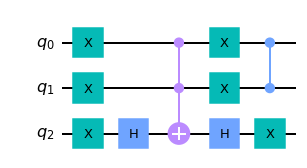

In [20]:
## Create an Oracle
N = 8 # the number of total items in the search space

m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')

num_solutions = 3

if num_solutions==4:

    # solutions are 010 and 001, 110 and 101
    myqc.x(1)
    myqc.z(range(2)) # this alone corresponds to solutions 000 and 011, 100 and 111
    myqc.x(1)

if num_solutions in [1,3]:
   # solution is 000
    myqc.x(range(m))
    
    # this alone corresponds to solution 111
    myqc.h(m-1) # hadamards used to rotate mcx to mcz
    myqc.mcx(list(range(m-1)),m-1)
    myqc.h(m-1)

    myqc.x(range(m))

if num_solutions in [2,3]:

    # solutions are 011 and 111

    myqc.cz(0,1)
    
Oracle = myqc.to_gate()

myqc.draw(output='mpl')

In [21]:
from qiskit.quantum_info import Statevector

hads = QuantumCircuit(m)
hads.h(range(m))
ket = Statevector(hads.compose(myqc))
ket.to_dict()

{'000': (-0.3535533905932736+0j),
 '001': (0.3535533905932736+0j),
 '010': (0.3535533905932736+0j),
 '011': (-0.3535533905932736+0j),
 '100': (0.3535533905932736+0j),
 '101': (0.3535533905932736+0j),
 '110': (0.3535533905932736+0j),
 '111': (-0.3535533905932736+0j)}

Construct the diffuser
$$
U_\phi =2|\phi><\phi| -I
$$
$$
H^{\otimes n} |0> =|\phi>
$$
$$
U_\phi =H^{\otimes{n}}(2|0><0| -I) H^{\otimes{n}}=
H^{\otimes{n}} U_0 H^{\otimes{n}}
$$

$U_0= - X^{\otimes{n}} (MCZ)X^{\otimes{n}}$ can be constructed by means of  a MCZ gate (Multi-controlled Z-gate). In qiskit we don't have this gate available, but this can be obtained with a MCX Gate with an Hadamard on the last quibit just before and after the toffoli. In fact $HXZ=Z$.

In particular $MCZ=(I^{\otimes{n-1}}) \otimes H) MCX (I^{\otimes{n-1}})) \otimes H)$. 
Combining everything we get

$$
U\phi=- H^{\otimes{n}} X^{\otimes{n}} (MCZ)X^{\otimes{n}}H^{\otimes{n}}=  (H^{\otimes{n-1}}\otimes I_2)(X^{\otimes{n-1}}\otimes I_2) MCX (X^{\otimes{n-1}}\otimes I_2)(H^{\otimes{n-1}}\otimes I_2)
$$



In [ ]:
## in this vesrion we do H and X an all the qubits hence we nee to do a MCZ which is done 

qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### your code goes here
for qubit in range(m):
    qc.h(qubit)
for qubit in range(m):
    qc.x(qubit)

## in this vesrion we do H and X an all the qubits hence we nee to do a MCZ which is done 
##
qc.h(m-1)
qc.mct(list(range(m-1)), m-1)
qc.h(m-1)

for qubit in range(m):
    qc.x(qubit)
for qubit in range(m):
    qc.h(qubit)

# get rid of the global phase -1
qc.z(0)
qc.x(0)
qc.z(0)
qc.x(0)
####
Grover = qc.to_gate()
#

We put everything together

In [ ]:
n=3
circ = QuantumCircuit(n)
circ.h(list(range(n)))
circ.append(Grover, range(n))
circ.measure_all()
circ.decompose().draw('mpl')

In [ ]:
sim = Aer.get_backend('aer_simulator')
shots = 20000

In [ ]:
####### Your code goes here
result= execute(circ, sim, shots=shots).result()
counts=result.get_counts(circ)
plot_histogram(counts)

### First Example ###
Let us implement the oracle of the logical expression

In [ ]:
log_expr='(~a | ~b | ~c) & (d | b | ~c) & (a | ~d | c) &(~a| d| ~b)'

based on the true table

In table form with each row being a 3-clause, x meaning "this variable false", o meaning "this variable true", and space meaning "not in clause":

| a | b | c | d |
|---|:---:|:---:|---:|
| x | x    |x    |   |
|   |  o   |x    | o  |
| o|     |o   | x  |
|x|x| |o|


In [ ]:
n=4
# oracle for the logical_expression 
# log_expr='(~a | ~b | ~c) & (d | b | ~c) & (a | ~d | c) &(~a| d| ~b)'
q_oracle = QuantumCircuit(2*n+1)
control1 = MCXGate(3, None, '111') #(~a | ~b | ~c)
q_oracle.append(control1, [0, 1, 2, 4])
control2 = MCXGate(3, None, '011') #( b | ~c| ~d)
q_oracle.append(control2, [1, 2, 3, 5])
control3 = MCXGate(3, None, '011') #(a | ~d | c)
q_oracle.append(control3, [0,2, 3, 6])
control4 = MCXGate(3, None, '101') #(~a| d| ~b)
q_oracle.append(control4, [0, 1, 3, 7])
control5 = MCXGate(4, None, '0000')
q_oracle.append(control5, [4,5,6,7,8])
q_oracle.z(8)
# uncompute
q_oracle.append(control5, [4,5,6,7,8])
q_oracle.append(control4, [0,1,3,7])
q_oracle.append(control3, [0,2,3,6])
q_oracle.append(control2, [1,2,3,5])
q_oracle.append(control1, [0,1,2,4])
q_oracle.draw('mpl')

Let us design the diffuser

In [ ]:
q_diffuser =  QuantumCircuit(n)
#### write your code here
q_diffuser.h(range(n))
q_diffuser.x(range(n))

q_diffuser.h(n-1)
q_diffuser.mct(list(range(n-1)), n-1)
q_diffuser.h(n-1)

q_diffuser.x(range(n))
q_diffuser.h(range(n))


In [ ]:
q_diffuser.draw('mpl')

In [ ]:
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(q_diffuser, backend))
job.result().get_unitary(q_diffuser, decimals=3)

In [ ]:
U=job.result().get_unitary(q_diffuser, decimals=3)
print(np.linalg.norm(U+(2*np.ones((2**n,2**n))/(2**n)-np.eye(2**n))))
#print((2*np.ones((2**n,2**n))/(2**n)-np.eye(2**n)))

We can transform averything into a circuit

In [2]:
def inizialize_phi(qcirc, nqubits):
    #### Write inizializatio to phi
    qcirc.h(range(nqubits))
    return qcirc

In [ ]:
n=4
def oracle_ex(n):
    # oracle for the logical_expression 
    # log_expr='(~a | ~b | ~c) & (d | b | ~c) & (a | ~d | c) &(~a| d| ~b)'
    q_oracle = QuantumCircuit(2*n+1)
    control1 = MCXGate(3, None, '111') #(~a | ~b | ~c)
    q_oracle.append(control1, [0, 1, 2, 4])
    control2 = MCXGate(3, None, '011') #( b | ~c| ~d)
    q_oracle.append(control2, [1, 2, 3, 5])
    control3 = MCXGate(3, None, '011') #(a | ~d | c)
    q_oracle.append(control3, [0,2, 3, 6])
    control4 = MCXGate(3, None, '101') #(~a| d| ~b)
    q_oracle.append(control4, [0, 1, 3, 7])
    control5 = MCXGate(4, None, '0000')
    q_oracle.append(control5, [4,5,6,7,8])
    q_oracle.z(8)
    # uncompute
    q_oracle.append(control5, [4,5,6,7,8])
    q_oracle.append(control4, [0,1,3,7])
    q_oracle.append(control3, [0,2,3,6])
    q_oracle.append(control2, [1,2,3,5])
    q_oracle.append(control1, [0,1,2,4])

    oracle = q_oracle.to_gate()
    oracle.name ="oracle"
    return oracle   

In [12]:
def diffuser(nv):
    qvar = QuantumRegister(nv)
    qtarget = QuantumRegister(1)
    qc = QuantumCircuit(qvar, qtarget, name='diffuser')
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nv):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nv):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    ## is realized avoiding the h and x on qtarget and applying just MCX
    qc.append(MCXGate(len(qvar)), qvar[0:]+qtarget[0:])
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nv):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nv):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diff"
    return U_s

Let us prove with a logic expression with only a solution

In [13]:
log_expr ='(𝐴|𝐵|𝐶)&(𝐴|𝐵|~𝐶)&(𝐴|~𝐵|𝐶)&(𝐴|~𝐵|~𝐶)&(~𝐴|𝐵|𝐶)&(~𝐴|𝐵|~𝐶)&(~𝐴|~𝐵|𝐶)'

we need to modify only the oracle

In [14]:
nc=7 # number of clauses
nv=3 # number of variables
def oracle_2(nv, nc):
    # oracle for the logical_expression 
    # log_expr ='(𝐴|𝐵|𝐶)&(𝐴|𝐵|~𝐶)&(𝐴|~𝐵|𝐶)&(𝐴|~𝐵|~𝐶)&(~𝐴|𝐵|𝐶)&(~𝐴|𝐵|~𝐶)&(~𝐴|~𝐵|𝐶)'
    qr = QuantumRegister(nv, 'val')
    qa = QuantumRegister(nc, 'work')
    q_checker = QuantumRegister(1, 'checker')
    q_oracle = QuantumCircuit(qr, qa, q_checker)
    control0= MCXGate(3, None, '000') #(𝐴|𝐵|𝐶)
    q_oracle.append(control0, qr[:]+[qa[0]])
    control1 = MCXGate(3, None, '001') #(𝐴|𝐵|~𝐶)
    q_oracle.append(control1, qr[:]+[qa[1]])
    control2 = MCXGate(3, None, '010') # (𝐴|~𝐵|𝐶)
    q_oracle.append(control2, qr[:]+qa[2:3])
    control3 = MCXGate(3, None, '011') #&(𝐴|~𝐵|~𝐶)
    q_oracle.append(control3, qr[:]+qa[3:4])
    control4 = MCXGate(3, None, '100') #(~𝐴|𝐵|𝐶)
    q_oracle.append(control4, qr[:]+qa[4:5])
    control5 = MCXGate(3, None, '101') #(~𝐴|𝐵|~𝐶)
    q_oracle.append(control5, qr[:]+qa[5:6])
    control6 = MCXGate(3, None, '110') #(~𝐴|~𝐵|𝐶)
    q_oracle.append(control6, qr[:]+qa[6:7])
    control7 = MCXGate(7, None, '0000000')
    q_oracle.append(control7, qa[:]+q_checker[0:1])
    q_oracle.z(q_checker[0])
    # uncompute
    q_oracle.append(control7, qa[:]+q_checker[0:1])
    q_oracle.append(control6, qr[:]+qa[6:7])
    q_oracle.append(control5, qr[:]+qa[5:6])
    q_oracle.append(control4, qr[:]+qa[4:5])
    q_oracle.append(control3, qr[:]+qa[3:4])
    q_oracle.append(control2, qr[:]+qa[2:3])
    q_oracle.append(control1, qr[:]+qa[1:2])
    q_oracle.append(control0, qr[:]+qa[0:1])
    q_oracle.draw('mpl')
    oracle = q_oracle.to_gate()
    oracle.name ="oracle"
    return q_oracle   

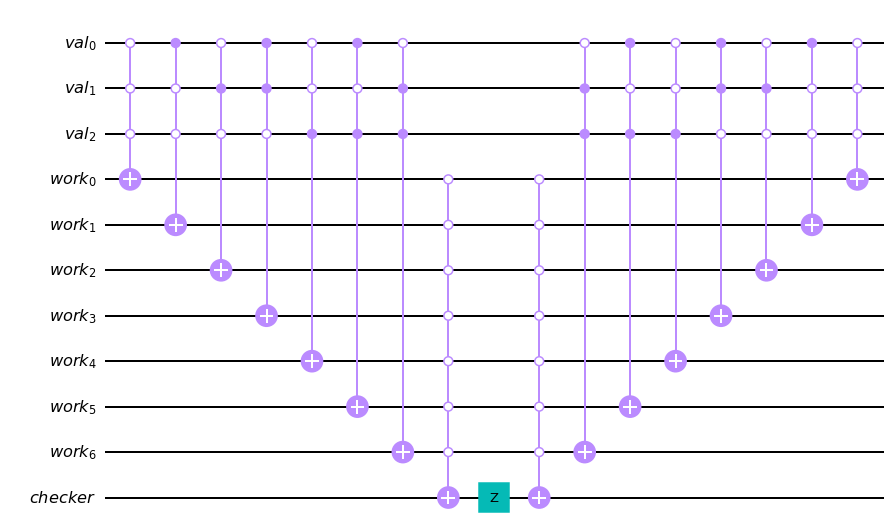

In [15]:
circ=oracle_2(nv, nc)
circ.draw('mpl')

2


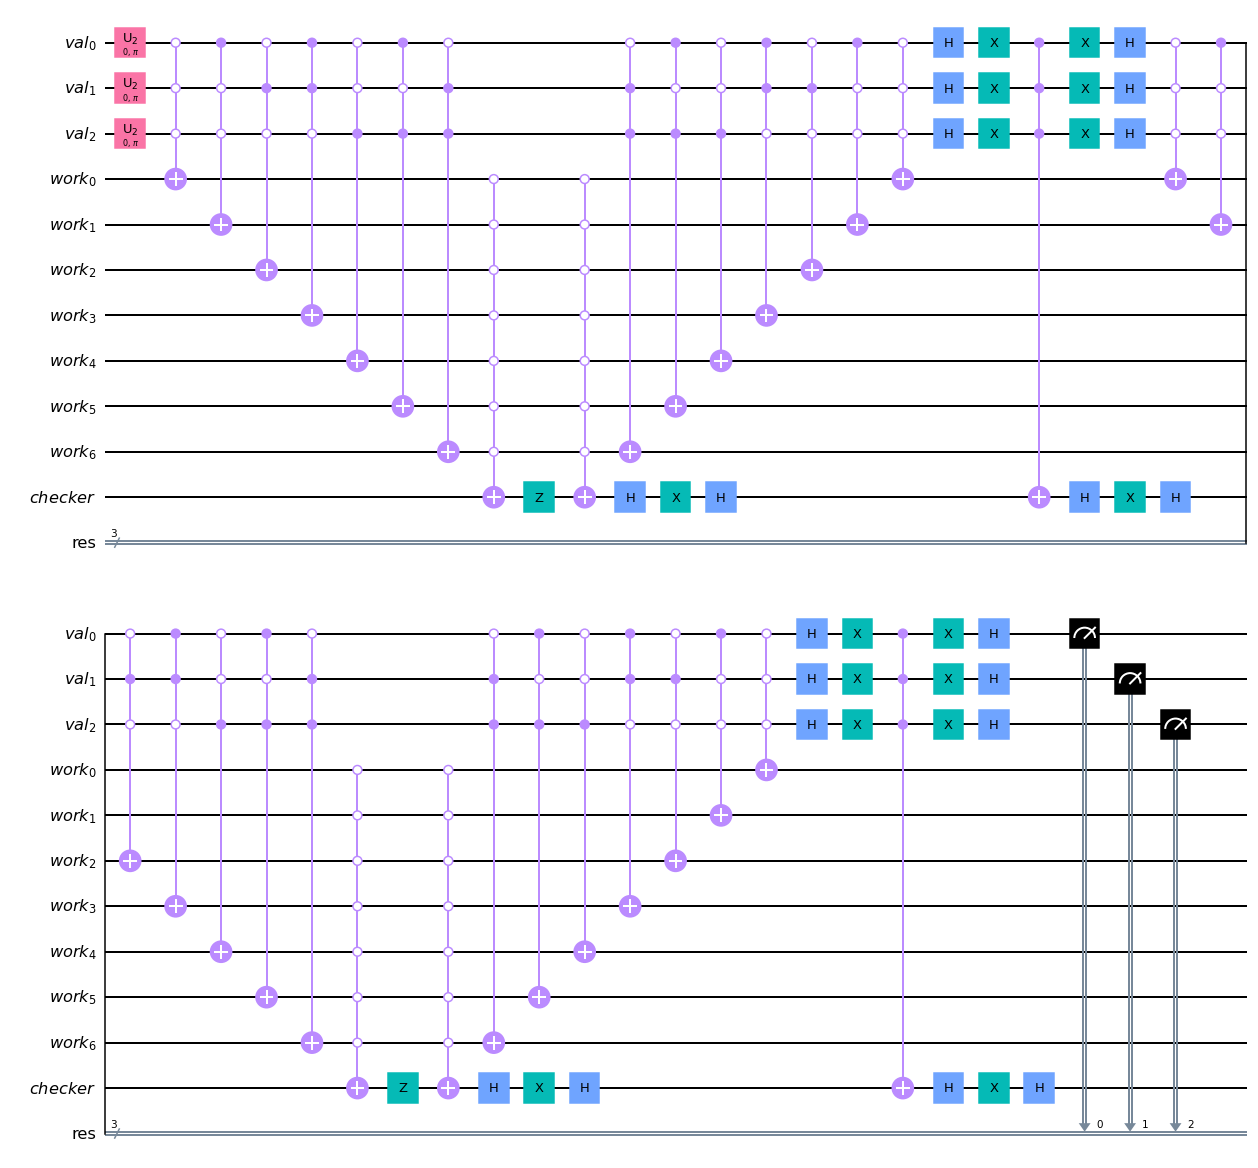

In [16]:
nv = 3
nc=7

qr = QuantumRegister(nv, 'val')
qa = QuantumRegister(nc, 'work')
q_checker = QuantumRegister(1, 'checker')
c = ClassicalRegister(nv, 'res')

sat_solver = QuantumCircuit(qr, qa, q_checker, c)

## inizialize to hadamard
sat_solver = inizialize_phi(sat_solver, nv)
n_solutions = 1 #known a priori somehow
iterations = math.floor(np.pi/4 * math.sqrt(2**len(qr)/n_solutions))
print(iterations)

for i in range(iterations):
    sat_solver.append(oracle_2(nv, nc), qr[:]+qa[:]+[q_checker])
    sat_solver.append(diffuser(nv), qr[:]+[q_checker])
    
for qubit in range(len(qr)):
    sat_solver.measure(qr[qubit],c[qubit])

sat_solver.decompose().draw('mpl')

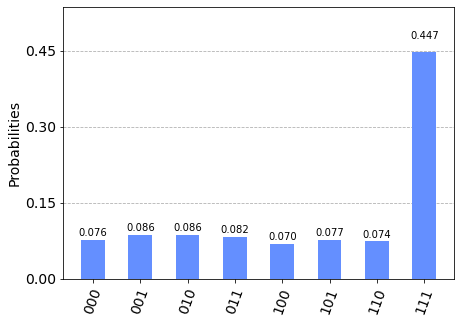

In [18]:
sim = Aer.get_backend('aer_simulator')
shots = 20000
####### Your code goes here
result= execute(sat_solver, sim, shots=2000).result()
counts=result.get_counts(sat_solver)
plot_histogram(counts)

In [11]:
oracle = PhaseOracle(log_expr)
oracle.draw('mpl')

NameError: name 'log_expr' is not defined

In [ ]:
backend= BasicAer.get_backend('qasm_simulator')

In [ ]:
problem = AmplificationProblem(oracle = oracle, is_good_state= oracle.evaluate_bitstring) 
grover = Grover(quantum_instance = backend)


In [ ]:
result = grover.amplify(problem) #is a GroverResult
print('Top measurement:', result.top_measurement)

In [ ]:
backend= BasicAer.get_backend('qasm_simulator')
problem = AmplificationProblem(oracle = oracle, is_good_state= oracle.evaluate_bitstring) 
#grover = Grover(quantum_instance = backend)
grover = Grover(iterations=2, quantum_instance = backend)
circ = grover.construct_circuit(problem)
circ.measure_all()
result= execute(sat_solver, sim, shots=2000).result()
counts=result.get_counts(sat_solver)
plot_histogram(counts)

In [ ]:
nv=3
nc=2
n_target=1
def oracle_3(nv, nc):
    # oracle for the logical_expression 
    # log_expr ='(𝐴|𝐵|𝐶)&(𝐴|𝐵|~𝐶)&(𝐴|~𝐵|𝐶)&(𝐴|~𝐵|~𝐶)&(~𝐴|𝐵|𝐶)&(~𝐴|𝐵|~𝐶)&(~𝐴|~𝐵|𝐶)'
    qr = QuantumRegister(nv, 'val')
    qa = QuantumRegister(nc, 'work')
    q_checker = QuantumRegister(1, 'checker')
    q_oracle = QuantumCircuit(qr, qa, q_checker)
    control0= MCXGate(3, None, '010') #(𝐴|~𝐵|𝐶)
    q_oracle.append(control0, qr[:]+[qa[0]])
    control1 = MCXGate(2, None, '01') #(𝐵|~𝐶)
    q_oracle.append(control1, qr[1:]+[qa[1]])
    control2 = MCXGate(2, None, '00')
    q_oracle.append(control2, qa[:]+[q_checker[0]])
    q_oracle.z(q_checker[0])
    # uncompute
    q_oracle.append(control2, qa[:]+[q_checker[0]])
    q_oracle.append(control1, qr[1:]+[qa[1]])
    q_oracle.append(control0, qr[:]+[qa[0]])
    q_oracle.draw('mpl')
    oracle = q_oracle.to_gate()
    oracle.name ="oracle"
    return q_oracle   

In [ ]:
qr = QuantumRegister(nv, 'val')
qa = QuantumRegister(nc, 'work')
q_checker = QuantumRegister(1, 'checker')
c = ClassicalRegister(nv, 'res')

sat_solver = QuantumCircuit(qr, qa, q_checker, c)

## inizialize to hadamard
sat_solver = inizialize_phi(sat_solver, nv)
n_solutions = 1 #known a priori somehow
iterations = math.floor(np.pi/4 * math.sqrt(2**len(qr)/n_solutions))
sat_solver.append(oracle_3(nv, nc), qr[:]+qa[:]+[q_checker])
sat_solver.decompose().draw('mpl')

In [ ]:
from qiskit.quantum_info import Statevector

backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(sat_solver, backend))
U=job.result().get_unitary(sat_solver, decimals=3)
print(U.shape)